In [103]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sympy as sp
#import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma

from sympy.interactive import printing
printing.init_printing()

In [104]:
# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

In [105]:
nobs = len(data)
theta = 0.6

In [70]:
data_numpy=[]
for i in data:
    data_numpy.append(i.detach().numpy())
data_numpy=np.array(data_numpy)

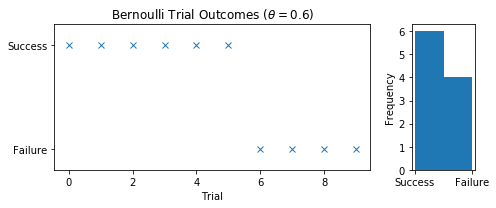

In [71]:
# Plot the data
fig = plt.figure(figsize=(7,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(range(nobs), data_numpy, 'x')
ax2.hist(-data_numpy, bins=2)

ax1.yaxis.set(ticks=(0,1), ticklabels=('Failure', 'Success'))
ax2.xaxis.set(ticks=(-1,0), ticklabels=('Success', 'Failure'));

ax1.set(title=r'Bernoulli Trial Outcomes $(\theta=0.6)$', xlabel='Trial', ylim=(-0.2, 1.2))
ax2.set(ylabel='Frequency')

fig.tight_layout()

# Likelihood

Consider a sample of $T$ draws from the random variable $y$. The joint likelihood of observing any specific sample $$Y = (y_1, …, y_T)’$$ is given by:

$$
\begin{align}
p(Y|\theta) & = \prod_{i=1}^T \theta^{y_i} (1-\theta)^{1-y_i} \\
& = \theta^{s} (1 - \theta)^{T-s}
\end{align} 
$$

where $s = \sum_i y_i$ is the number of observed “successes”, and $T−s$  is the number of observed “failures”.

In [72]:
t, T, s = sp.symbols('theta, T, s')

# Create the function symbolically
likelihood = (t**s)*(1-t)**(T-s)

# Convert it to a Numpy-callable function
_likelihood = sp.lambdify((t,T,s), likelihood, modules='numpy')

# Prior

$$
p(\theta;\alpha_1,\alpha_2) = \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1}
$$

Prior mean: 0.5


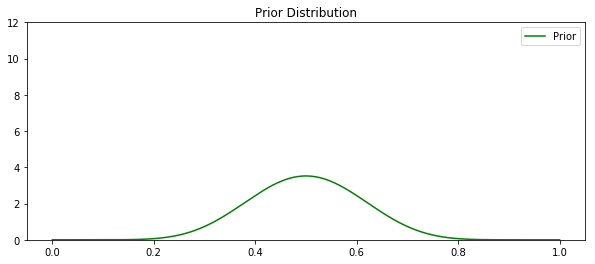

In [73]:
# Prior Mean
a1=10
a2=10
prior_mean = a1 / (a1 + a2)
print('Prior mean:', prior_mean)

# Plot the prior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g');

# Cleanup
ax.set(title='Prior Distribution', ylim=(0,12))
ax.legend(['Prior']);

# Posterior Analytical

$$
\begin{align}
p(\theta|Y;\alpha_1,\alpha_2) & = \frac{P(Y|\theta) P(\theta)}{P(Y)} \\
& \propto P(Y|\theta) P(\theta) \\
& = \theta^s (1-\theta)^{T-s} \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1} \\
& \propto \theta^{s+\alpha_1-1} (1 - \theta)^{T-s+\alpha_2 - 1} \\
\end{align}
$$

The last line is identifiable as the kernel of a beta distribution with parameters

$$
(\hat \alpha_1, \hat \alpha_2) = (s+\alpha_1, T-s+\alpha_2)
$$

Thus the posterior is given by

$$
P(\theta|Y;\alpha_1,\alpha_2) = \frac{1}{B(\hat \alpha_1, \hat \alpha_2)} \theta^{\hat \alpha_1 - 1} (1-\theta)^{\hat \alpha_2 -1}
$$

In [74]:
# Find the hyperparameters of the posterior
a1_hat = a1 + data_numpy.sum()
a2_hat = a2 + nobs - data_numpy.sum()

# Posterior Mean
post_mean = a1_hat / (a1_hat + a2_hat)
print('Posterior Mean (Analytic):', post_mean)

Posterior Mean (Analytic): 0.5333333333333333


In [76]:

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()


def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')


....................

In [77]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


based on the data and our prior belief, the fairness of the coin is 0.532 +- 0.090


In [80]:
# Variational Distribution
Samples = 1000
q=[] 
for i in range(Samples):
    q.append(pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q)).detach().numpy())

## Samples of Joint Density Function

In [82]:
Pos = stats.beta(a1_hat,a2_hat).pdf(q)

In [83]:
Ratio = []
ind = 0
for i in Pos:
    Ratio.append(np.log(i/q[ind]))
    ind+=1

In [86]:
print(psisloo(np.array(Ratio)))
print('K:'+str(psisloo(np.array(Ratio))[2]))

(1.3133609730738494, 1.3133609730738494, 0.6274897068988206)
K:0.6274897068988206


In [101]:
neg_log = [] # To Test if the log weights need to be negative for the psislw function
for i in Ratio:
    i=i*-1
    neg_log.append(i)

In [102]:
psislw(np.array(neg_log)) # Indeed this function takes in negative logweights. 

(array([-6.97324641, -7.55484924, -7.59744063, -7.67731221, -7.66229159,
        -6.91504265, -7.42471549, -7.67705527, -7.39931505, -7.67833003,
        -7.62282202, -6.83949447, -5.02114792, -7.20742965, -7.66869764,
        -7.33411633, -7.39115456, -7.22552025, -7.46797315, -7.54740873,
        -7.69985495, -7.69977834, -7.69828022, -7.68361361, -6.2096801 ,
        -7.59914906, -6.52762115, -6.69203103, -7.66753224, -7.65649604,
        -7.40655121, -7.69667652, -7.06308216, -5.38598399, -7.5590258 ,
        -7.09274429, -7.64509698, -7.25203608, -5.12013232, -7.43878905,
        -7.10392344, -7.2797011 , -7.7023703 , -7.04003629, -5.31961285,
        -7.51924485, -7.41203263, -7.3497636 , -7.69499295, -7.61750864,
        -7.70223446, -7.62996212, -7.29055637, -7.49864277, -7.63690261,
        -7.66510934, -7.69521955, -7.0860709 , -7.31804035, -7.39547796,
        -7.66914913, -7.54241517, -7.64657259, -7.52503224, -6.93051776,
        -7.70106867, -6.91248775, -6.57089349, -7.6

In [96]:
psislw(np.array(Ratio)) # Without negative weights.

(array([ -7.29033551,  -6.70873268,  -6.66614129,  -6.58626971,
         -6.60129034,  -7.34853928,  -6.83886643,  -6.58652665,
         -6.86426687,  -6.5852519 ,  -6.64075991,  -7.42408745,
         -9.34705426,  -7.05615227,  -6.59488428,  -6.92946559,
         -6.87242736,  -7.03806167,  -6.79560877,  -6.71617319,
         -6.56372697,  -6.56380358,  -6.56530171,  -6.57996831,
         -8.04113301,  -6.66443286,  -7.73596077,  -7.57155089,
         -6.59604969,  -6.60708588,  -6.85703071,  -6.56690541,
         -7.20049976,  -8.86440308,  -6.70455612,  -7.17083763,
         -6.61848494,  -7.01154584,  -9.19074766,  -6.82479288,
         -7.15965849,  -6.98388083,  -6.56121162,  -7.22354563,
         -8.98494525,  -6.74433707,  -6.8515493 ,  -6.91381832,
         -6.56858898,  -6.64607328,  -6.56134747,  -6.6336198 ,
         -6.97302555,  -6.76493915,  -6.62667932,  -6.59847258,
         -6.56836237,  -7.17751102,  -6.94554158,  -6.86810396,
         -6.59443279,  -6.72116675,  -6.

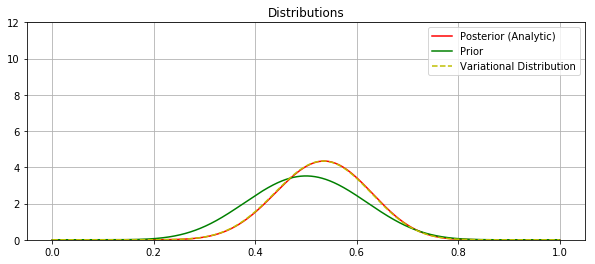

In [94]:
# Plot the analytic posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1_hat, a2_hat).pdf(X), 'r');
#ax.plot(X, stats.beta(alpha_q, beta_q).pdf(X), 'y');

# Plot the prior
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g');
ax.plot(X, stats.beta(alpha_q, beta_q).pdf(X), 'y--');
plt.grid()
# Cleanup
ax.set(title='Distributions', ylim=(0,12))
ax.legend(['Posterior (Analytic)', 'Prior','Variational Distribution']);

In [58]:
def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.

    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).

    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).

    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.

    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces

    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    #print('Ks'+str(ks))
    return loo, loos, ks

def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).

    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.

    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``

    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.

    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices

    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)
    #print(kss)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k
        #print(k)

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss

def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.

    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.

    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out
def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)

    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.

    Parameters
    ----------
    x : ndarray
        One dimensional data array

    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.

    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).

    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.

    Returns
    -------
    k, sigma : float
        estimated parameter values

    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.

    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.

    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        #print('K:'+str(k))
        return k, sigma, ks, w
    else:
        #print('K:'+str(k))
        return k, sigma

def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x

In [95]:
Ratio